### Linear Regression
Aggregating the dataset per month

In [208]:
import pandas as pd 

In [209]:
# Time frame for forecasts_and_truth is 2021-01 ~ 2022-05
df_1 = pd.read_csv('forecasts_and_truth.csv')
display(df_1.head())

,target_variable,target_end_date,location,location_name,temporal_resolution,population,geo_type,geo_value,abbreviation,full_location_name,...,type,forecast_value,truth_source,truth_value,abs_error,forecast_week,target_week,model_type,model_type.general,abs_error_per10k.pop
0,inc case,2020-04-11,01,Alabama,wk,4903185,state,al,AL,Alabama,...,point,920.0,Observed Data (NYTimes),1630,710.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,1.448038
1,inc case,2020-04-11,02,Alaska,wk,731545,state,ak,AK,Alaska,...,point,86.0,Observed Data (NYTimes),86,0.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.000000
2,inc case,2020-04-11,04,Arizona,wk,7278717,state,az,AZ,Arizona,...,point,1414.0,Observed Data (NYTimes),1374,40.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.054955
3,inc case,2020-04-11,05,Arkansas,wk,3017804,state,ar,AR,Arkansas,...,point,334.0,Observed Data (NYTimes),485,151.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.500364
4,inc case,2020-04-11,06,California,wk,39512223,state,ca,CA,California,...,point,7742.0,Observed Data (NYTimes),8625,883.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.223475


In [210]:
# Filter DataFrame for 'inc case' and 'inc death'
df_case = df_1[df_1['target_variable'] == 'inc case']
df_death = df_1[df_1['target_variable'] == 'inc death']

# Pivot the DataFrames to create separate columns for 'inc case' and 'inc death'
df_case_pivoted = df_case.pivot_table(index=['location_name', 'population', 'target_end_date'], values='truth_value', columns='target_variable').reset_index()
df_death_pivoted = df_death.pivot_table(index=['location_name', 'population', 'target_end_date'], values='truth_value', columns='target_variable').reset_index()

# Rename the columns for clarity
df_case_pivoted.columns = ['location_name', 'population', 'target_end_date', 'inc_case']
df_death_pivoted.columns = ['location_name', 'population', 'target_end_date', 'inc_death']

# Merge the DataFrames on common columns
df_combined = pd.merge(df_case_pivoted, df_death_pivoted, how='outer', on=['location_name', 'population', 'target_end_date'])

# Display the resulting DataFrame
display(df_combined)

,location_name,population,target_end_date,inc_case,inc_death
0,Alabama,4903185,2020-03-28,NaN,0.0
1,Alabama,4903185,2020-03-30,NaN,6.0
2,Alabama,4903185,2020-03-31,NaN,3.0
3,Alabama,4903185,2020-04-01,NaN,14.0
4,Alabama,4903185,2020-04-02,NaN,4.0
...,...,...,...,...,...
12073,Wyoming,578759,2022-04-09,114.0,5.0
12074,Wyoming,578759,2022-04-16,-23.0,5.0
12075,Wyoming,578759,2022-04-23,134.0,6.0
12076,Wyoming,578759,2022-04-30,158.0,5.0


In [211]:
# Rename the column 'state_abbreviation' to 'abbreviation'
df_combined = df_combined.rename(columns={'location_name': 'location_key'})

# Create a list of column names to keep
columns_to_keep = ['location_key', 'population', 'inc_case', 'inc_death', 'target_end_date']
# Select only the specified columns
df_combined = df_combined[columns_to_keep]

# Convert the 'target_end_date' column to datetime
df_combined['target_end_date'] = pd.to_datetime(df_combined['target_end_date'])
# Extract the month from the 'target_end_date' column
df_combined['date'] = df_combined['target_end_date'].dt.to_period('M')
df_combined.drop(columns=['target_end_date'], inplace=True)

# Take data from 2021-01 to 2022-05
start_date = '2021-01'
end_date = '2022-05'

date_mask = (df_combined['date'] >= start_date) & (df_combined['date'] <= end_date)
df_combined = df_combined[date_mask]

display(df_combined)

,location_key,population,inc_case,inc_death,date
145,Alabama,4903185,26000.0,187.0,2021-01
146,Alabama,4903185,29692.0,427.0,2021-01
147,Alabama,4903185,21531.0,820.0,2021-01
148,Alabama,4903185,18761.0,538.0,2021-01
149,Alabama,4903185,16140.0,909.0,2021-01
...,...,...,...,...,...
12073,Wyoming,578759,114.0,5.0,2022-04
12074,Wyoming,578759,-23.0,5.0,2022-04
12075,Wyoming,578759,134.0,6.0,2022-04
12076,Wyoming,578759,158.0,5.0,2022-04


In [212]:
# Group by state abbreviation and date - then take the sum of the truth value
# Inc case is the number of covid cases on average per state
# Take the average population of each state per month
cases_per_state = df_combined.groupby(['location_key', 'date']).agg({'inc_case': 'sum', 'inc_death' : 'sum', 'population': 'mean'}).reset_index()

state_mapping = {
    'US_AL': 'Alabama',
    'US_AK': 'Alaska',
    'US_AZ': 'Arizona',
    'US_AR': 'Arkansas',
    'US_CA': 'California',
    'US_CO': 'Colorado',
    'US_CT': 'Connecticut',
    'US_DE': 'Delaware',
    'US_FL': 'Florida',
    'US_GA': 'Georgia',
    'US_HI': 'Hawaii',
    'US_ID': 'Idaho',
    'US_IL': 'Illinois',
    'US_IN': 'Indiana',
    'US_IA': 'Iowa',
    'US_KS': 'Kansas',
    'US_KY': 'Kentucky',
    'US_LA': 'Louisiana',
    'US_ME': 'Maine',
    'US_MD': 'Maryland',
    'US_MA': 'Massachusetts',
    'US_MI': 'Michigan',
    'US_MN': 'Minnesota',
    'US_MS': 'Mississippi',
    'US_MO': 'Missouri',
    'US_MT': 'Montana',
    'US_NE': 'Nebraska',
    'US_NV': 'Nevada',
    'US_NH': 'New Hampshire',
    'US_NJ': 'New Jersey',
    'US_NM': 'New Mexico',
    'US_NY': 'New York',
    'US_NC': 'North Carolina',
    'US_ND': 'North Dakota',
    'US_OH': 'Ohio',
    'US_OK': 'Oklahoma',
    'US_OR': 'Oregon',
    'US_PA': 'Pennsylvania',
    'US_RI': 'Rhode Island',
    'US_SC': 'South Carolina',
    'US_SD': 'South Dakota',
    'US_TN': 'Tennessee',
    'US_TX': 'Texas',
    'US_UT': 'Utah',
    'US_VT': 'Vermont',
    'US_VA': 'Virginia',
    'US_WA': 'Washington',
    'US_WV': 'West Virginia',
    'US_WI': 'Wisconsin',
    'US_WY': 'Wyoming'
}

# Display the modified DataFrame
display(cases_per_state.head())

,location_key,date,inc_case,inc_death,population
0,Alabama,2021-01,112124.0,2881.0,4903185.0
1,Alabama,2021-02,37101.0,2364.0,4903185.0
2,Alabama,2021-03,21389.0,596.0,4903185.0
3,Alabama,2021-04,11826.0,325.0,4903185.0
4,Alabama,2021-05,17507.0,295.0,4903185.0


In [213]:
index_df = pd.read_csv('index.csv')
display(index_df.head())

,location_key,place_id,wikidata_id,datacommons_id,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,locality_code,locality_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level
0,AD,ChIJlfCemC71pRIRkn_qeNc-yQc,Q228,country/AND,AD,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,AD,AND,0
1,AE,ChIJvRKrsd9IXj4RpwoIwFYv0zM,Q878,country/ARE,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,AE,ARE,0
2,AF,ChIJbQL_-LZu0TgReNqWvg1GtfM,Q889,country/AFG,AF,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,AF,AFG,0
3,AF_BAL,ChIJWZOescNSyzgRkmVJ8fmfR3k,Q121104,NaN,AF,Afghanistan,BAL,Balkh,NaN,NaN,NaN,NaN,AF,AFG,1
4,AF_BAM,ChIJw-bKQwDr0jgRQiw8jHsQ-HI,Q171382,NaN,AF,Afghanistan,BAM,Bamyan,NaN,NaN,NaN,NaN,AF,AFG,1


In [214]:
# Drop rows with missing values in the 'location_key' column
index_df = index_df.dropna(subset=['location_key'])

# Filter rows with 'US_' prefix in the 'location_key' column
index_df = index_df[index_df['location_key'].str.startswith('US_')]

# Display the filtered DataFrame
display(index_df.head())

,location_key,place_id,wikidata_id,datacommons_id,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,locality_code,locality_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level
19558,US_AK,ChIJG8CuwJzfAFQRNduKqSde27w,Q797,geoId/02,US,United States of America,AK,Alaska,NaN,NaN,NaN,NaN,US,USA,1
19559,US_AK_02013,ChIJ7a-UgVuW_lYRjTetzbIWL48,Q504371,geoId/02013,US,United States of America,AK,Alaska,02013,Aleutians East,NaN,NaN,US,USA,2
19560,US_AK_02016,ChIJI9ivbI1Pg1cRg8d4nlGjGVU,Q185533,geoId/02016,US,United States of America,AK,Alaska,02016,Aleutians West,NaN,NaN,US,USA,2
19561,US_AK_02020,ChIJQT-zBHaRyFYR42iEp1q6fSU,Q39450,geoId/02020,US,United States of America,AK,Alaska,02020,Anchorage Municipality,NaN,NaN,US,USA,2
19562,US_AK_02050,ChIJAzKaLtLCIVcR4HXf_qNNZmk,Q500312,geoId/02050,US,United States of America,AK,Alaska,02050,Bethel,NaN,NaN,US,USA,2


#### Variabe 1: vaccination search trends

In [215]:
# Time frame for Global_vaccination_search_insights.csv is 2021-01 ~ 2024-01
vaccination_search_df = pd.read_csv('Global_vaccination_search_insights.csv')
display(vaccination_search_df.head())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_85393/858233779.py:2: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccination_search_df = pd.read_csv('Global_vaccination_search_insights.csv')


,date,country_region,country_region_code,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,sub_region_3,sub_region_3_code,place_id,sni_covid19_vaccination,sni_vaccination_intent,sni_safety_side_effects
0,2021-01-04,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,31.019,7.318,5.726
1,2021-01-11,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,34.325,10.416,4.572
2,2021-01-18,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,33.666,9.689,5.406
3,2021-01-25,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,37.693,10.678,6.204
4,2021-02-01,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,45.849,13.942,7.218


In [216]:
vaccination_search_df['date'] = pd.to_datetime(vaccination_search_df['date'])
vaccination_search_df['date'] = vaccination_search_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
start_date = '2021-01'
end_date = '2022-05'

date_mask = (vaccination_search_df['date'] >= start_date) & (vaccination_search_df['date'] <= end_date)
vaccination_search_df = vaccination_search_df[date_mask]

# Group by 'sub_region_1' and calculate the mean of 'sni_covid19_vaccination'
vaccination_search_df = vaccination_search_df.groupby(['sub_region_1', 'date'])['sni_covid19_vaccination'].mean().reset_index()

# Assuming vaccination_df_filtered is the DataFrame containing data for the 51 US states

# Rename the column 'old_column_name' to 'new_column_name'
vaccination_search_df = vaccination_search_df.rename(columns={'sub_region_1': 'location_key'})

# Print the DataFrame to verify the changes
display(vaccination_search_df)

,location_key,date,sni_covid19_vaccination
0,Alabama,2021-01,37.048310
1,Alabama,2021-02,47.069826
2,Alabama,2021-03,53.624391
3,Alabama,2021-04,39.750964
4,Alabama,2021-05,22.192073
...,...,...,...
1729,Yukon,2022-01,82.347600
1730,Yukon,2022-02,37.905000
1731,Yukon,2022-03,23.877500
1732,Yukon,2022-04,25.379500


In [217]:
# List of US states
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
    'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
    'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
    'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
    'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

# Filter the DataFrame to include only the US states
vaccination_search_df = vaccination_search_df[vaccination_search_df['location_key'].isin(us_states)]

# Now df_us_states contains only the rows corresponding to the US states
display(vaccination_search_df)

,location_key,date,sni_covid19_vaccination
0,Alabama,2021-01,37.048310
1,Alabama,2021-02,47.069826
2,Alabama,2021-03,53.624391
3,Alabama,2021-04,39.750964
4,Alabama,2021-05,22.192073
...,...,...,...
1712,Wyoming,2022-01,32.042965
1713,Wyoming,2022-02,9.253333
1714,Wyoming,2022-03,7.990414
1715,Wyoming,2022-04,7.072492


In [218]:
merged_df = pd.merge(cases_per_state, vaccination_search_df, on=['location_key', 'date'])
display(merged_df)

,location_key,date,inc_case,inc_death,population,sni_covid19_vaccination
0,Alabama,2021-01,112124.0,2881.0,4903185.0,37.048310
1,Alabama,2021-02,37101.0,2364.0,4903185.0,47.069826
2,Alabama,2021-03,21389.0,596.0,4903185.0,53.624391
3,Alabama,2021-04,11826.0,325.0,4903185.0,39.750964
4,Alabama,2021-05,17507.0,295.0,4903185.0,22.192073
...,...,...,...,...,...,...
845,Wyoming,2022-01,30284.0,99.0,578759.0,32.042965
846,Wyoming,2022-02,10383.0,93.0,578759.0,9.253333
847,Wyoming,2022-03,1147.0,65.0,578759.0,7.990414
848,Wyoming,2022-04,494.0,29.0,578759.0,7.072492


#### Variable 2: new persons vaccinated

In [219]:
#Time frame for vaccination.csv is 2021-01 ~ 2022-09
vaccination_df = pd.read_csv('vaccinations.csv')
display(vaccination_df)

In [ ]:
vaccination_df['date'] = pd.to_datetime(vaccination_df['date'])
vaccination_df['date'] = vaccination_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (vaccination_df['date'] >= start_date) & (vaccination_df['date'] <= end_date)
vaccination_df = vaccination_df[date_mask]

vaccination_df = vaccination_df.dropna(subset=['location_key'])

# Take rows with the states within the US
vaccination_df = vaccination_df[vaccination_df['location_key'].str.startswith('US_')]

# Take the last value per state, since it is the cumulative number of vaccinated people
vaccination_df = vaccination_df.groupby(['location_key', 'date'])['new_persons_vaccinated'].sum().reset_index()

# Rename the location_key values to state name
vaccination_df['location_key'] = vaccination_df['location_key'].map(state_mapping)
vaccination_df.dropna(inplace=True)

display(vaccination_df.head())

,location_key,date,new_persons_vaccinated
0,Alaska,2021-01,72403.0
1,Alaska,2021-02,71846.0
2,Alaska,2021-03,81976.0
3,Alaska,2021-04,56684.0
4,Alaska,2021-05,31972.0


#### Variable 3: stringency index

In [ ]:
# Time frame for oxford-government-response.csv is 2020-01 ~ 2022-07
government_df = pd.read_csv('oxford-government-response (1).csv')
display(government_df.head())

,date,location_key,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,...,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
0,2020-01-01,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Drop all columns except location_key, date, and stringency_index
columns_to_keep = ['location_key', 'date', 'stringency_index']
government_df = government_df[columns_to_keep]

government_df['date'] = pd.to_datetime(government_df['date'])
government_df['date'] = government_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (government_df['date'] >= start_date) & (government_df['date'] <= end_date)
government_df = government_df[date_mask]

government_df = government_df.dropna(subset=['location_key'])
government_df = government_df[government_df['location_key'].str.startswith('US_')]
state_mapping = {
    'US_AL': 'Alabama',
    'US_AK': 'Alaska',
    'US_AZ': 'Arizona',
    'US_AR': 'Arkansas',
    'US_CA': 'California',
    'US_CO': 'Colorado',
    'US_CT': 'Connecticut',
    'US_DE': 'Delaware',
    'US_FL': 'Florida',
    'US_GA': 'Georgia',
    'US_HI': 'Hawaii',
    'US_ID': 'Idaho',
    'US_IL': 'Illinois',
    'US_IN': 'Indiana',
    'US_IA': 'Iowa',
    'US_KS': 'Kansas',
    'US_KY': 'Kentucky',
    'US_LA': 'Louisiana',
    'US_ME': 'Maine',
    'US_MD': 'Maryland',
    'US_MA': 'Massachusetts',
    'US_MI': 'Michigan',
    'US_MN': 'Minnesota',
    'US_MS': 'Mississippi',
    'US_MO': 'Missouri',
    'US_MT': 'Montana',
    'US_NE': 'Nebraska',
    'US_NV': 'Nevada',
    'US_NH': 'New Hampshire',
    'US_NJ': 'New Jersey',
    'US_NM': 'New Mexico',
    'US_NY': 'New York',
    'US_NC': 'North Carolina',
    'US_ND': 'North Dakota',
    'US_OH': 'Ohio',
    'US_OK': 'Oklahoma',
    'US_OR': 'Oregon',
    'US_PA': 'Pennsylvania',
    'US_RI': 'Rhode Island',
    'US_SC': 'South Carolina',
    'US_SD': 'South Dakota',
    'US_TN': 'Tennessee',
    'US_TX': 'Texas',
    'US_UT': 'Utah',
    'US_VT': 'Vermont',
    'US_VA': 'Virginia',
    'US_WA': 'Washington',
    'US_WV': 'West Virginia',
    'US_WI': 'Wisconsin',
    'US_WY': 'Wyoming'
}
government_df['location_key'] = government_df['location_key'].map(state_mapping)
display(government_df.head())

,location_key,date,stringency_index
246828,Alaska,2021-01,61.57
246829,Alaska,2021-01,61.57
246830,Alaska,2021-01,61.57
246831,Alaska,2021-01,61.57
246832,Alaska,2021-01,61.57


In [ ]:
# Take the average of the stringency index per state
government_df = government_df.groupby(['location_key', 'date'])['stringency_index'].mean().reset_index()
display(government_df)

# Print the DataFrame with only one row for each unique location key
#display(df_unique)

,location_key,date,stringency_index
0,Alabama,2021-01,44.775484
1,Alabama,2021-02,46.300000
2,Alabama,2021-03,45.403226
3,Alabama,2021-04,37.962667
4,Alabama,2021-05,34.260000
...,...,...,...
845,Wyoming,2022-01,37.960000
846,Wyoming,2022-02,39.743929
847,Wyoming,2022-03,39.810000
848,Wyoming,2022-04,39.810000


#### Variable 4: mobility

In [ ]:
mobility_df = pd.read_csv('Global_Mobility_Report.csv')
display(mobility_df.head())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_85393/3931906409.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  mobility_df = pd.read_csv('Global_Mobility_Report.csv')


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [ ]:
# Filter country_region_code to the United States
mobility_df = mobility_df[mobility_df['country_region_code'] == 'US']

# Take the month of the date column
mobility_df['date'] = pd.to_datetime(mobility_df['date'])
mobility_df['date'] = mobility_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (mobility_df['date'] >= start_date) & (mobility_df['date'] <= end_date)
mobility_df = mobility_df[date_mask]

# List categories to aggregate
categories = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline',
              'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']

mobility_df = mobility_df.groupby(['sub_region_1', 'date'])[categories].mean().reset_index()
mobility_df = mobility_df.rename(columns={'sub_region_1': 'location_key'})

display(mobility_df)

,location_key,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,2021-01,-13.719270,-7.474860,-17.004246,-17.576642,-20.699692,7.784854
1,Alabama,2021-02,-12.376876,-4.243556,-16.628770,-16.794165,-18.556306,7.211556
2,Alabama,2021-03,2.409203,2.510350,7.673267,-0.463158,-16.489383,3.921010
3,Alabama,2021-04,6.684211,6.936989,23.053763,7.049922,-15.939426,2.476230
4,Alabama,2021-05,5.362963,11.820097,28.986486,9.037936,-16.462051,2.577686
...,...,...,...,...,...,...,...,...
862,Wyoming,2022-01,-15.174041,-12.708791,-6.651163,-6.778571,-18.134003,5.173077
863,Wyoming,2022-02,-8.228013,-9.240741,0.905172,-4.444882,-14.590317,2.770833
864,Wyoming,2022-03,-7.630058,-11.094444,11.507812,0.365591,-14.752902,1.733333
865,Wyoming,2022-04,-6.405970,-9.130682,21.752066,-4.161049,-15.437063,0.996094


In [ ]:
# Filter the DataFrame to include only the US states
mobility_df = mobility_df[mobility_df['location_key'].isin(us_states)]

# Now dataframe contains only the rows corresponding to the US states
display(mobility_df)

,location_key,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,2021-01,-13.719270,-7.474860,-17.004246,-17.576642,-20.699692,7.784854
1,Alabama,2021-02,-12.376876,-4.243556,-16.628770,-16.794165,-18.556306,7.211556
2,Alabama,2021-03,2.409203,2.510350,7.673267,-0.463158,-16.489383,3.921010
3,Alabama,2021-04,6.684211,6.936989,23.053763,7.049922,-15.939426,2.476230
4,Alabama,2021-05,5.362963,11.820097,28.986486,9.037936,-16.462051,2.577686
...,...,...,...,...,...,...,...,...
862,Wyoming,2022-01,-15.174041,-12.708791,-6.651163,-6.778571,-18.134003,5.173077
863,Wyoming,2022-02,-8.228013,-9.240741,0.905172,-4.444882,-14.590317,2.770833
864,Wyoming,2022-03,-7.630058,-11.094444,11.507812,0.365591,-14.752902,1.733333
865,Wyoming,2022-04,-6.405970,-9.130682,21.752066,-4.161049,-15.437063,0.996094


#### Variable 5: hospitalisation

In [ ]:
hospitalisation_df = pd.read_csv('hospitalizations.csv')
display(hospitalisation_df.head())

,date,location_key,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,new_intensive_care_patients,cumulative_intensive_care_patients,current_intensive_care_patients,new_ventilator_patients,cumulative_ventilator_patients,current_ventilator_patients
0,0022-01-10,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,0022-01-20,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,0202-03-30,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,0221-07-06,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1202-01-07,AR,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
# Take rows with the states within the US
hospitalisation_df = hospitalisation_df[1711321:]
hospitalisation_df['location_key'] = hospitalisation_df['location_key'].map(state_mapping)

# Take the month of the date column
hospitalisation_df['date'] = pd.to_datetime(hospitalisation_df['date'])
hospitalisation_df['date'] = hospitalisation_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (hospitalisation_df['date'] >= start_date) & (hospitalisation_df['date'] <= end_date)
hospitalisation_df = hospitalisation_df[date_mask]

# Group by 'location_key' and 'date' and calculate the sum of new hospitalized patients per month
hospitalisation_df = hospitalisation_df.groupby(['location_key', 'date']).agg({'new_hospitalized_patients': 'sum'}).reset_index()

display(hospitalisation_df.head())

,location_key,date,new_hospitalized_patients
0,Alabama,2021-01,11105.0
1,Alabama,2021-02,4420.0
2,Alabama,2021-03,2206.0
3,Alabama,2021-04,1708.0
4,Alabama,2021-05,1815.0


#### Variable 5: demographics

In [ ]:
age_df = pd.read_csv('demographics.csv')

display(age_df.head())

,location_key,population,population_male,population_female,population_rural,population_urban,population_largest_city,population_clustered,population_density,human_development_index,population_age_00_09,population_age_10_19,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_and_older
0,AD,77265.0,58625.0,55581.0,9269.0,67873.0,NaN,NaN,164.394,0.858,9370.0,12022.0,10727.0,12394.0,21001.0,20720.0,14433.0,8657.0,4881.0
1,AE,9890400.0,6836349.0,3054051.0,1290785.0,8479744.0,2833079.0,5914068.0,118.306,0.863,1011713.0,842991.0,2149343.0,3169314.0,1608109.0,797913.0,242707.0,55884.0,12426.0
2,AF,38928341.0,19976265.0,18952076.0,28244481.0,9797273.0,4114030.0,4114030.0,59.627,0.498,11088732.0,9821559.0,7035871.0,4534646.0,2963459.0,1840198.0,1057496.0,480455.0,105925.0
3,AF_BAL,1509183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AF_BAM,495557.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
age_df = age_df.dropna(subset=['location_key'])
age_df = age_df[age_df['location_key'].str.startswith('US_')]

columns_to_keep = ['location_key', 'population_age_00_09',	'population_age_10_19',	'population_age_20_29',	'population_age_30_39',	'population_age_40_49',	'population_age_50_59',	'population_age_60_69',	'population_age_70_79',	'population_age_80_and_older']

# Filter the DataFrame to keep only the desired columns
age_df = age_df[columns_to_keep]

# Take rows with the states within the US
age_df = age_df[age_df['location_key'].str.startswith('US_')]

age_df['location_key'] = age_df['location_key'].apply(lambda x: 'US_' + x.split('_')[1] if '_' in x else x)

state_mapping = {
    'US_AL': 'Alabama',
    'US_AK': 'Alaska',
    'US_AZ': 'Arizona',
    'US_AR': 'Arkansas',
    'US_CA': 'California',
    'US_CO': 'Colorado',
    'US_CT': 'Connecticut',
    'US_DE': 'Delaware',
    'US_FL': 'Florida',
    'US_GA': 'Georgia',
    'US_HI': 'Hawaii',
    'US_ID': 'Idaho',
    'US_IL': 'Illinois',
    'US_IN': 'Indiana',
    'US_IA': 'Iowa',
    'US_KS': 'Kansas',
    'US_KY': 'Kentucky',
    'US_LA': 'Louisiana',
    'US_ME': 'Maine',
    'US_MD': 'Maryland',
    'US_MA': 'Massachusetts',
    'US_MI': 'Michigan',
    'US_MN': 'Minnesota',
    'US_MS': 'Mississippi',
    'US_MO': 'Missouri',
    'US_MT': 'Montana',
    'US_NE': 'Nebraska',
    'US_NV': 'Nevada',
    'US_NH': 'New Hampshire',
    'US_NJ': 'New Jersey',
    'US_NM': 'New Mexico',
    'US_NY': 'New York',
    'US_NC': 'North Carolina',
    'US_ND': 'North Dakota',
    'US_OH': 'Ohio',
    'US_OK': 'Oklahoma',
    'US_OR': 'Oregon',
    'US_PA': 'Pennsylvania',
    'US_RI': 'Rhode Island',
    'US_SC': 'South Carolina',
    'US_SD': 'South Dakota',
    'US_TN': 'Tennessee',
    'US_TX': 'Texas',
    'US_UT': 'Utah',
    'US_VT': 'Vermont',
    'US_VA': 'Virginia',
    'US_WA': 'Washington',
    'US_WV': 'West Virginia',
    'US_WI': 'Wisconsin',
    'US_WY': 'Wyoming'
}
age_df['location_key'] = age_df['location_key'].map(state_mapping)

# Take the sum of the population for each age group per state
age_groups = ['population_age_00_09', 'population_age_10_19', 'population_age_20_29', 'population_age_30_39', 'population_age_40_49', 'population_age_50_59', 'population_age_60_69', 'population_age_70_79', 'population_age_80_and_older']
age_df = age_df.groupby('location_key')[age_groups].sum().reset_index()

display(age_df)

,location_key,population_age_00_09,population_age_10_19,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_and_older
0,Alabama,1217833.0,1287203.0,1369008.0,1284380.0,1216604.0,1326993.0,1227186.0,766193.0,373032.0
1,Alaska,221603.0,207335.0,245395.0,221399.0,189235.0,212882.0,161665.0,69785.0,27242.0
2,Arizona,1969877.0,1991766.0,2104604.0,2002802.0,1749975.0,1787427.0,1782600.0,1188507.0,578421.0
3,Arkansas,797888.0,806557.0,846765.0,803269.0,728897.0,782481.0,748359.0,483056.0,243766.0
4,California,10337314.0,10746862.0,12158586.0,11653181.0,10266652.0,10105297.0,8414870.0,4986191.0,2850169.0
5,Colorado,1468398.0,1464599.0,1673878.0,1709815.0,1465274.0,1493696.0,1271154.0,681261.0,346612.0
6,Connecticut,799617.0,939138.0,930224.0,899716.0,948841.0,1053655.0,881095.0,527093.0,345941.0
7,Delaware,232065.0,245260.0,263495.0,246480.0,237588.0,266635.0,258252.0,162873.0,79924.0
8,Florida,4662177.0,4937926.0,5511639.0,5373268.0,5252534.0,5645577.0,5642463.0,4072829.0,2244058.0
9,Georgia,3396344.0,3499601.0,3598733.0,3627323.0,3389823.0,3239052.0,2675076.0,1484928.0,683613.0


In [ ]:
# Reduce dimensionality of age groups to three groups

children = ['population_age_00_09', 'population_age_10_19']
adult = ['population_age_20_29', 'population_age_30_39', 'population_age_40_49', 'population_age_50_59']
elderly = ['population_age_60_69', 'population_age_70_79', 'population_age_80_and_older']

age_df['children'] = age_df[children].sum(axis=1)
age_df['adult'] = age_df[adult].sum(axis=1)
age_df['elderly'] = age_df[elderly].sum(axis=1)

age_df = age_df.drop(columns=age_groups)

display(age_df.head())

,location_key,children,adult,elderly
0,Alabama,2505036.0,5196985.0,2366411.0
1,Alaska,428938.0,868911.0,258692.0
2,Arizona,3961643.0,7644808.0,3549528.0
3,Arkansas,1604445.0,3161412.0,1475181.0
4,California,21084176.0,44183716.0,16251230.0


In [ ]:
# Display the shapes of DataFrames before merging
print("Shape of vaccination_search_df:", vaccination_search_df.shape)
print("Shape of vaccination_df:", vaccination_df.shape)
print("Shape of government_df:", government_df.shape)
print("Shape of mobility_df:", mobility_df.shape)
print("Shape of hospitalisation_df:", hospitalisation_df.shape)
print("Shape of age_df:", age_df.shape)

Shape of vaccination_search_df: (850, 3)
Shape of vaccination_df: (850, 3)
Shape of government_df: (850, 3)
Shape of mobility_df: (850, 8)
Shape of hospitalisation_df: (850, 3)
Shape of age_df: (50, 4)


In [ ]:
# Merge vaccination_search, vaccination, government_response, loaction_key, and cases
merged_df = pd.merge(cases_per_state, vaccination_search_df, on=['location_key', 'date'])

# Merge the resulting dataframe with vaccination_df on the 'location_key' and 'date' column
merged_df = pd.merge(merged_df, age_df, on=['location_key'])
merged_df = pd.merge(merged_df, vaccination_df, on=['location_key', 'date'])
merged_df = pd.merge(merged_df, government_df, on=['location_key', 'date'])
merged_df = pd.merge(merged_df, mobility_df, on=['location_key', 'date'])
merged_df_final = pd.merge(merged_df, hospitalisation_df, on=['location_key', 'date'])

# Display the resulting DataFrame
display(merged_df_final)

,location_key,date,inc_case,inc_death,population,sni_covid19_vaccination,children,adult,elderly,new_persons_vaccinated,stringency_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,new_hospitalized_patients
0,Alabama,2021-01,112124.0,2881.0,4903185.0,37.048310,2505036.0,5196985.0,2366411.0,227440.0,44.775484,-13.719270,-7.474860,-17.004246,-17.576642,-20.699692,7.784854,11105.0
1,Alabama,2021-02,37101.0,2364.0,4903185.0,47.069826,2505036.0,5196985.0,2366411.0,351444.0,46.300000,-12.376876,-4.243556,-16.628770,-16.794165,-18.556306,7.211556,4420.0
2,Alabama,2021-03,21389.0,596.0,4903185.0,53.624391,2505036.0,5196985.0,2366411.0,505394.0,45.403226,2.409203,2.510350,7.673267,-0.463158,-16.489383,3.921010,2206.0
3,Alabama,2021-04,11826.0,325.0,4903185.0,39.750964,2505036.0,5196985.0,2366411.0,434379.0,37.962667,6.684211,6.936989,23.053763,7.049922,-15.939426,2.476230,1708.0
4,Alabama,2021-05,17507.0,295.0,4903185.0,22.192073,2505036.0,5196985.0,2366411.0,176537.0,34.260000,5.362963,11.820097,28.986486,9.037936,-16.462051,2.577686,1815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,Wyoming,2022-01,30284.0,99.0,578759.0,32.042965,313061.0,638520.0,275909.0,7963.0,37.960000,-15.174041,-12.708791,-6.651163,-6.778571,-18.134003,5.173077,646.0
846,Wyoming,2022-02,10383.0,93.0,578759.0,9.253333,313061.0,638520.0,275909.0,4374.0,39.743929,-8.228013,-9.240741,0.905172,-4.444882,-14.590317,2.770833,473.0
847,Wyoming,2022-03,1147.0,65.0,578759.0,7.990414,313061.0,638520.0,275909.0,2327.0,39.810000,-7.630058,-11.094444,11.507812,0.365591,-14.752902,1.733333,133.0
848,Wyoming,2022-04,494.0,29.0,578759.0,7.072492,313061.0,638520.0,275909.0,2441.0,39.810000,-6.405970,-9.130682,21.752066,-4.161049,-15.437063,0.996094,45.0


In [ ]:
"""from sklearn.preprocessing import StandardScaler

columns_to_normalize = ['inc_death', 'population', 'sni_covid19_vaccination', 'new_persons_vaccinated',	'stringency_index',	'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',	'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'new_hospitalized_patients', 'children', 'adult', 'elderly']

scaler = StandardScaler()

merged_df_final[columns_to_normalize] = scaler.fit_transform(merged_df_final[columns_to_normalize])

display(merged_df_final.head())"""

,location_key,date,inc_case,inc_death,population,sni_covid19_vaccination,children,adult,elderly,new_persons_vaccinated,stringency_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,new_hospitalized_patients
0,Alabama,2021-01,112124.0,1.585399,-0.226564,0.031997,-0.23121,-0.236644,-0.198309,-0.111326,0.498760,-1.143758,-1.227587,-1.007846,-0.703170,-0.398907,1.143486,0.960431
1,Alabama,2021-02,37101.0,1.195824,-0.226564,0.472835,-0.23121,-0.236644,-0.198309,0.112097,0.634711,-1.028458,-0.888986,-1.000682,-0.661838,0.009115,0.927061,0.020666
2,Alabama,2021-03,21389.0,-0.136416,-0.226564,0.761165,-0.23121,-0.236644,-0.198309,0.389475,0.554740,0.241540,-0.181258,-0.537001,0.200799,0.402581,-0.315151,-0.290574
3,Alabama,2021-04,11826.0,-0.340623,-0.226564,0.150885,-0.23121,-0.236644,-0.198309,0.261525,-0.108781,0.608726,0.282600,-0.243542,0.597655,0.507273,-0.860569,-0.360582
4,Alabama,2021-05,17507.0,-0.363229,-0.226564,-0.621516,-0.23121,-0.236644,-0.198309,-0.203040,-0.438971,0.495242,0.794291,-0.130346,0.702666,0.407784,-0.822269,-0.345540


In [ ]:
from sklearn.preprocessing import MinMaxScaler

#to standarize the coefficients i normalized the columns that will be used in the regression model
columns_to_normalize = ['inc_case',	'inc_death', 'population', 'sni_covid19_vaccination', 'new_persons_vaccinated',	'stringency_index',	'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',	'parks_percent_change_from_baseline',	'transit_stations_percent_change_from_baseline',	'workplaces_percent_change_from_baseline',	'residential_percent_change_from_baseline',	'new_hospitalized_patients', 'population_age_00_09', 'population_age_10_19',	'population_age_20_29',	'population_age_30_39',	'population_age_40_49',	'population_age_50_59',	'population_age_60_69',	'population_age_70_79',	'population_age_80_and_older']

scaler = MinMaxScaler()

#normalize the selected columns
merged_df_final[columns_to_normalize] = scaler.fit_transform(merged_df_final[columns_to_normalize])

display(merged_df_final)

"from sklearn.preprocessing import MinMaxScaler\n\n#to standarize the coefficients i normalized the columns that will be used in the regression model\ncolumns_to_normalize = ['inc_case',\t'inc_death', 'population', 'sni_covid19_vaccination', 'new_persons_vaccinated',\t'stringency_index',\t'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',\t'parks_percent_change_from_baseline',\t'transit_stations_percent_change_from_baseline',\t'workplaces_percent_change_from_baseline',\t'residential_percent_change_from_baseline',\t'new_hospitalized_patients', 'population_age_00_09', 'population_age_10_19',\t'population_age_20_29',\t'population_age_30_39',\t'population_age_40_49',\t'population_age_50_59',\t'population_age_60_69',\t'population_age_70_79',\t'population_age_80_and_older']\n\nscaler = MinMaxScaler()\n\n#normalize the selected columns\nmerged_df_final[columns_to_normalize] = scaler.fit_transform(merged_df_final[columns_to_normalize])\n\

In [ ]:
# Save dataframe as a csv file to apply it to other models
merged_df_final.to_csv('merged_covid.csv', index=False)

#### Fit data to a linear regression model

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

state_dummies = pd.get_dummies(merged_df_final['location_key'], prefix ='state', drop_first=True)

merged_df_final = pd.concat([merged_df_final, state_dummies], axis=1)

# Define your design matrix and your target variable 
X = merged_df_final[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'new_hospitalized_patients', 'children', 'adult', 'elderly']]
y = merged_df_final['inc_case']

# Add a constant to the features to account for the intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     177.5
Date:                Sat, 23 Mar 2024   Prob (F-statistic):          7.91e-239
Time:                        16:24:29   Log-Likelihood:                -10895.
No. Observations:                 850   AIC:                         2.182e+04
Df Residuals:                     835   BIC:                         2.189e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

#### Correlation matrix

In [ ]:
merged_df_final = merged_df_final.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = X.corr()
display("Correlation Matrix:", corr_matrix)


'Correlation Matrix:'

,const,sni_covid19_vaccination,new_persons_vaccinated,stringency_index,inc_death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,new_hospitalized_patients,children,adult,elderly
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sni_covid19_vaccination,NaN,1.000000,0.460188,0.573527,0.150024,-0.256168,-0.186869,-0.110912,-0.323619,-0.558874,0.530245,0.181563,0.058833,0.073793,0.081138
new_persons_vaccinated,NaN,0.460188,1.000000,0.340868,0.426822,-0.154781,-0.145780,-0.113990,-0.153636,-0.255712,0.212421,0.358969,0.602729,0.608219,0.602092
stringency_index,NaN,0.573527,0.340868,1.000000,0.160227,-0.473875,-0.452468,-0.257595,-0.394142,-0.465402,0.564567,0.047703,0.054383,0.065068,0.049660
inc_death,NaN,0.150024,0.426822,0.160227,1.000000,-0.329065,-0.269197,-0.299631,-0.172942,-0.122035,0.327855,0.758544,0.610823,0.608034,0.614640
retail_and_recreation_percent_change_from_baseline,NaN,-0.256168,-0.154781,-0.473875,-0.329065,1.000000,0.899076,0.787637,0.713464,0.360391,-0.818556,-0.265029,-0.146012,-0.155645,-0.154455
grocery_and_pharmacy_percent_change_from_baseline,NaN,-0.186869,-0.145780,-0.452468,-0.269197,0.899076,1.000000,0.743934,0.624570,0.236952,-0.676204,-0.179557,-0.108229,-0.109553,-0.099035
parks_percent_change_from_baseline,NaN,-0.110912,-0.113990,-0.257595,-0.299631,0.787637,0.743934,1.000000,0.425213,0.096708,-0.608447,-0.258004,-0.148512,-0.144188,-0.143029
transit_stations_percent_change_from_baseline,NaN,-0.323619,-0.153636,-0.394142,-0.172942,0.713464,0.624570,0.425213,1.000000,0.426627,-0.704868,-0.136915,-0.118364,-0.142302,-0.140435
workplaces_percent_change_from_baseline,NaN,-0.558874,-0.255712,-0.465402,-0.122035,0.360391,0.236952,0.096708,0.426627,1.000000,-0.576502,-0.178790,-0.129846,-0.142685,-0.123236


/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


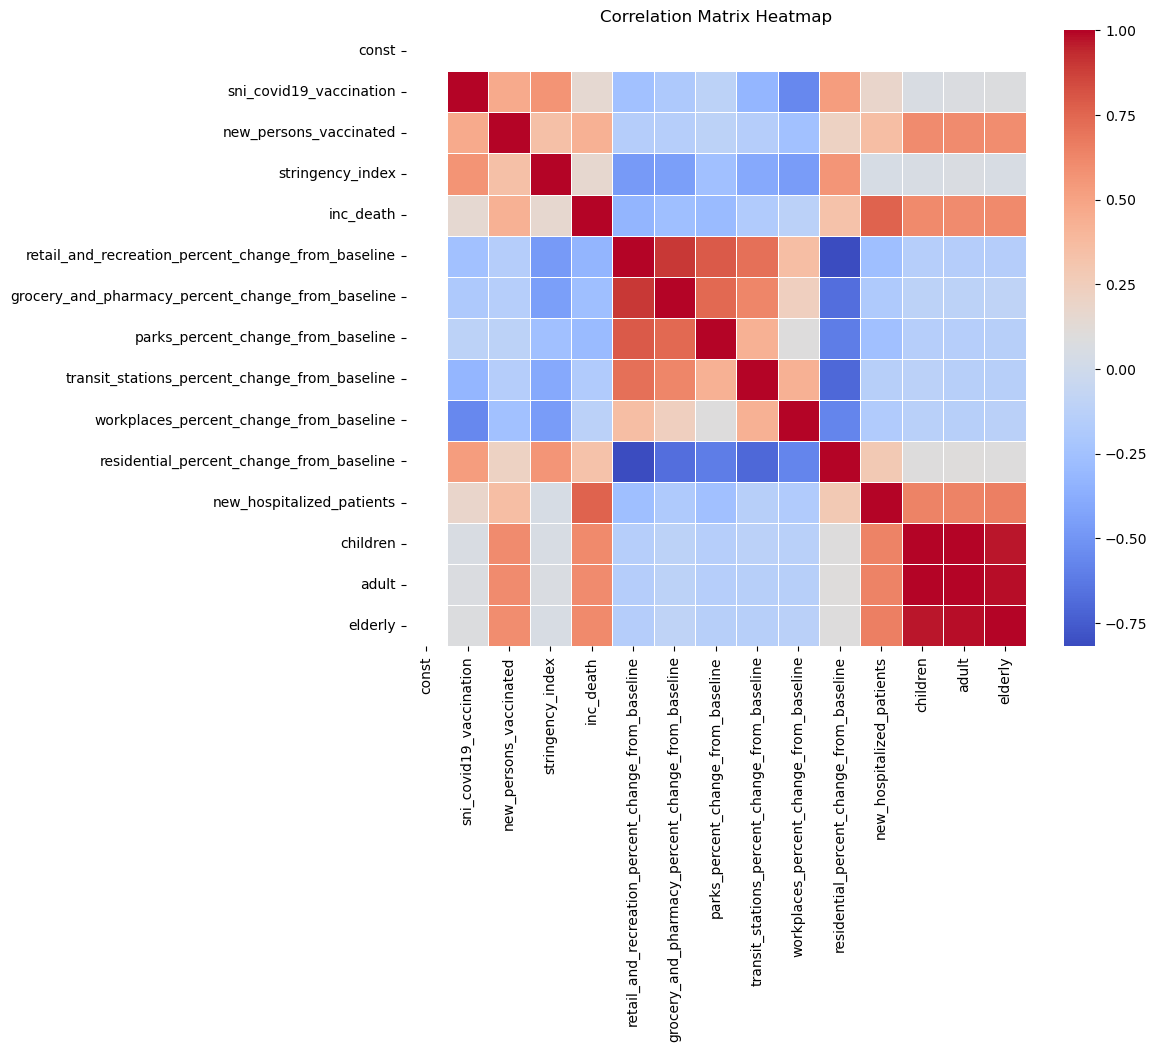

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap showing correlation matrix is decent
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

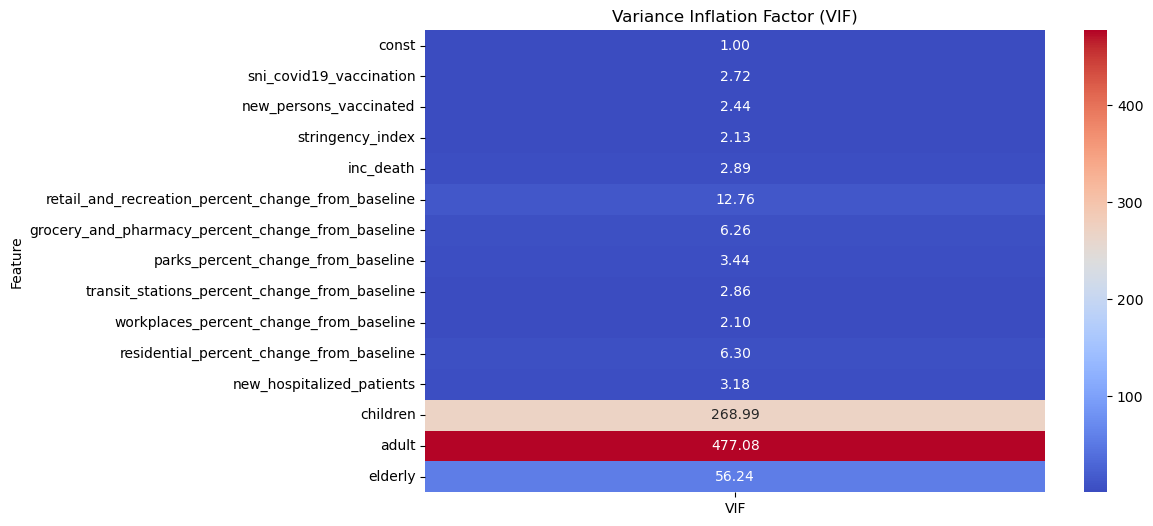

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF assess the multicollinearity between features
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

plt.figure(figsize=(10, 6))
sns.heatmap(vif_data.set_index('Feature'), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Variance Inflation Factor (VIF)")
plt.show()

# Retail and grocery percent change from baseline might be problematic features


### Evaluation metrics

##### Root Mean Squared Error (RMSE)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear regression model
model = sm.OLS(y_train, X_train).fit()

# Get predictions
y_predictions = model.predict(X_test)

# Check model accuracy
mse = mean_squared_error(y_test, y_predictions)
rmse = math.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 80342.16454524713


#### Fit data to a linear regression model without highly correlated covariates

In [ ]:
import statsmodels.api as sm

merged_df_final = pd.read_csv('merged_covid.csv')

# Define your design matrix and your target variable 
X = merged_df_final[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'new_hospitalized_patients', 'children', 'adult', 'elderly']]
y = merged_df_final['inc_case']

# Add a constant to the features to account for the intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     205.7
Date:                Sat, 23 Mar 2024   Prob (F-statistic):          5.94e-240
Time:                        16:24:34   Log-Likelihood:                -10898.
No. Observations:                 850   AIC:                         2.182e+04
Df Residuals:                     837   BIC:                         2.188e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [ ]:
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear regression model
model = sm.OLS(y_train, X_train).fit()

# Get predictions
y_predictions = model.predict(X_test)

# Check model accuracy
mse = mean_squared_error(y_test, y_predictions)
rmse = math.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 79738.67537419293


/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


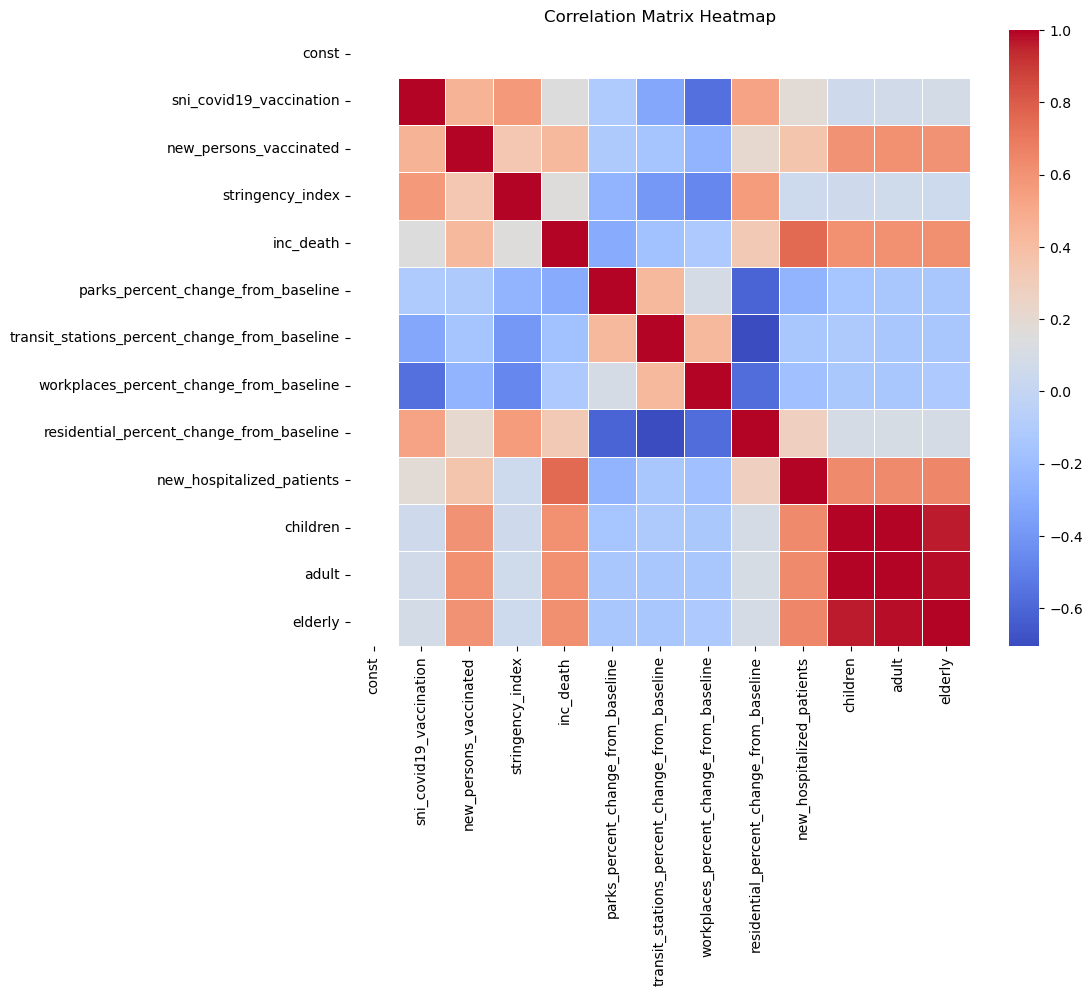

In [ ]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Try PCA instead for the mobility variables

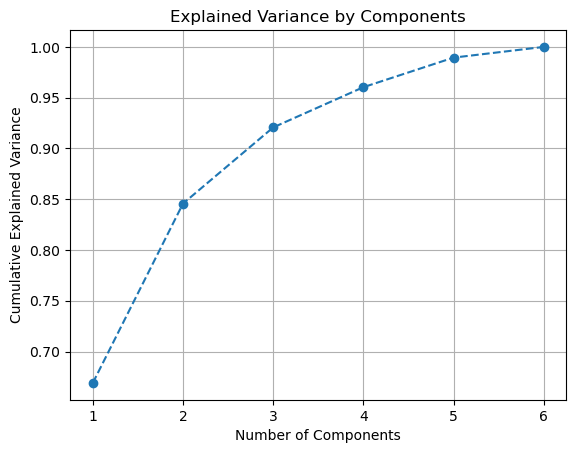

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mobility_variables = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']

X = merged_df_final[mobility_variables]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Determine the number of components
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

# Plot the explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

In [ ]:
n_components = 3
mobility_reduced = X_pca[:, :n_components]
mobility_reduced_df = pd.DataFrame(mobility_reduced, columns=[f'PC{i+1}' for i in range(n_components)])

In [ ]:
display(mobility_reduced_df.head()) 

,PC1,PC2,PC3
0,2.377275,-0.267974,-0.155950
1,1.954932,-0.527701,0.001533
2,-0.147857,-0.681883,-0.173546
3,-1.072898,-0.644503,-0.262684
4,-1.289049,-0.404806,-0.361771


In [ ]:
import statsmodels.api as sm

merged_df_final = pd.read_csv('merged_covid.csv')

# Add mobility reduced to the dataframe
merged_df_final = pd.concat([merged_df_final, mobility_reduced_df], axis=1)

# Define your design matrix and your target variable 
X = merged_df_final[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'PC1', 'PC2', 'PC3', 'new_hospitalized_patients', 'children', 'adult', 'elderly']]
y = merged_df_final['inc_case']

# Add a constant to the features to account for the intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())
# Evaluation metrics: RMSE, standardization, intercorrelation, demographics + age

                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     218.9
Date:                Sat, 23 Mar 2024   Prob (F-statistic):          1.19e-237
Time:                        16:25:02   Log-Likelihood:                -10906.
No. Observations:                 850   AIC:                         2.184e+04
Df Residuals:                     838   BIC:                         2.189e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
# Save dataframe as a csv file to apply it to other models
merged_df_final.to_csv('PCA_merged_covid.csv', index=False)

In [ ]:
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear regression model
model = sm.OLS(y_train, X_train).fit()

# Get predictions
y_predictions = model.predict(X_test)

# Check model accuracy
mse = mean_squared_error(y_test, y_predictions)
rmse = math.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 80710.84106215516


##### Correlation matrix

/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


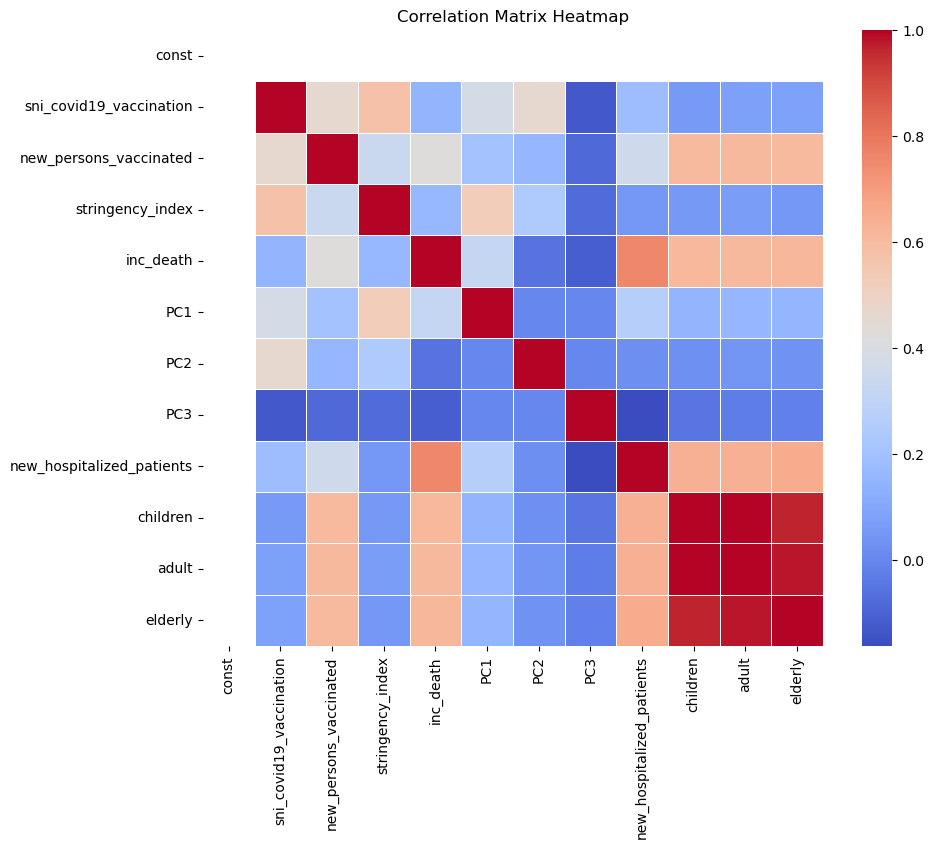

In [ ]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

0 sni_covid19_vaccination
1 new_persons_vaccinated
2 stringency_index
3 inc_death
4 PC1
5 PC2
6 PC3
7 new_hospitalized_patients
8 children
9 adult
10 elderly


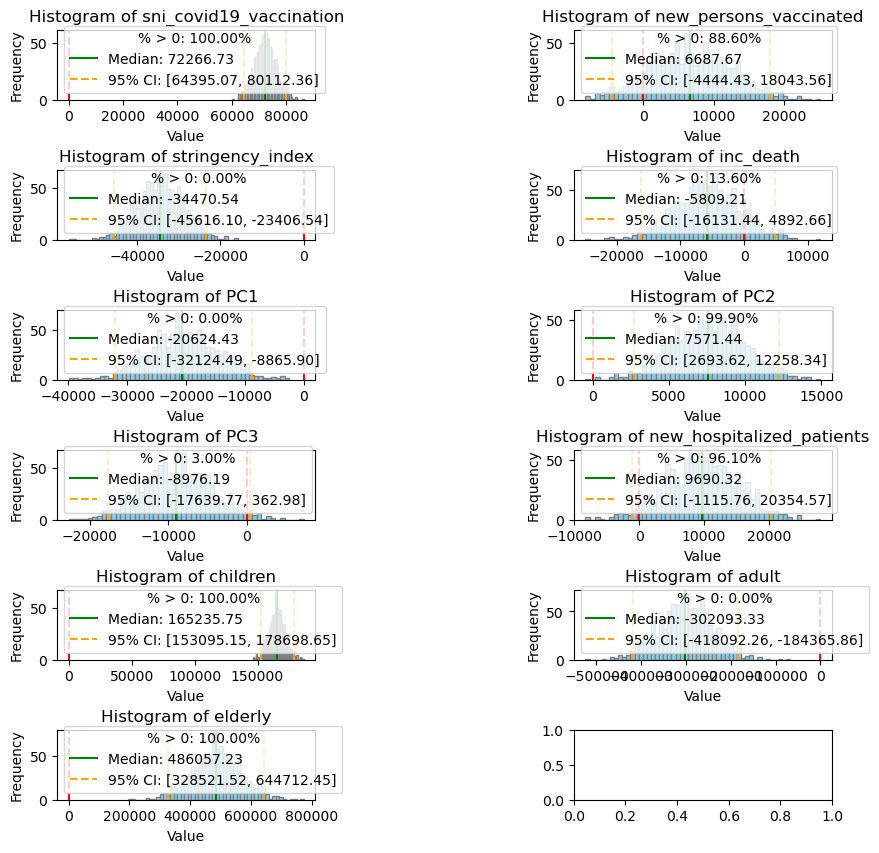

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate values from empirical posterior distribution of model coefficients
n = 1000
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), n)

#plot the histogram for each coefficient simulation
parameter_names = ['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'new_hospitalized_patients', 'children', 'adult', 'elderly']
n_params = len(parameter_names)

fig, axs = plt.subplots(6, 2, figsize=(10, 10))
axes_flat = axs.flatten()

for i, name in enumerate(parameter_names):
    print(i, name)
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    confidence_interval = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100  # Percentage of simulations > 0

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

plt.subplots_adjust(hspace=1, wspace=1)
plt.show()